In [26]:
from pickletools import optimize
from statistics import mode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

import tushare as ts
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

stock_code = '300750.SZ'

features = ['open', 'high', 'low', 'close', 'vol', 'amount']

ts.set_token('51fd5a77415e6299ad8243e387472a5552e3d24f5c889781caef6d89')
data = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date='20120101', end_date='20211231')
data['date'] = pd.to_datetime(data['trade_date'], format = "%Y/%m/%d %H:%M:%S")
data.set_index('date', inplace=True)  # 设置索引覆盖原来的数据
data = data.sort_index(ascending=True)  # 将时间顺序升序，符合时间序列
#data = data[['high', 'low', 'open', 'close', 'vol']]
print(data)
# ['ts_code', 'open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount']
"""
company = 'FB'

start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 1, 5)
data = web.DataReader(company, 'yahoo', start, end)

print(list(data))
"""
"""
                  High         Low        Open       Close    Volume   Adj Close
Date                                                                            
2021-09-17  371.410004  361.589996  371.410004  364.720001  26299000  364.720001
2021-09-20  361.029999  349.799988  359.299988  355.700012  19822800  355.700012
2021-09-21  360.040009  355.190002  358.500000  357.480011  11751900  357.480011
"""

              ts_code trade_date      open      high       low     close  \
date                                                                       
2018-06-11  300750.SZ   20180611   30.0498   36.0558   30.0498   36.0558   
2018-06-12  300750.SZ   20180612   39.6614   39.6614   39.6614   39.6614   
2018-06-13  300750.SZ   20180613   43.6255   43.6255   43.6255   43.6255   
2018-06-14  300750.SZ   20180614   47.9880   47.9880   47.9880   47.9880   
2018-06-15  300750.SZ   20180615   52.7888   52.7888   52.7888   52.7888   
...               ...        ...       ...       ...       ...       ...   
2021-12-27  300750.SZ   20211227  574.2000  587.9900  573.5000  578.6000   
2021-12-28  300750.SZ   20211228  578.0000  587.2800  569.9100  585.0000   
2021-12-29  300750.SZ   20211229  585.0000  585.9900  569.7800  575.5500   
2021-12-30  300750.SZ   20211230  577.0000  596.2900  575.5700  590.0000   
2021-12-31  300750.SZ   20211231  598.3000  605.9900  582.0000  588.0000   

           

'\n                  High         Low        Open       Close    Volume   Adj Close\nDate                                                                            \n2021-09-17  371.410004  361.589996  371.410004  364.720001  26299000  364.720001\n2021-09-20  361.029999  349.799988  359.299988  355.700012  19822800  355.700012\n2021-09-21  360.040009  355.190002  358.500000  357.480011  11751900  357.480011\n'

In [27]:
# prepare data
# scale down the 
scaler = MinMaxScaler(feature_range=(0,1))
raw_data = data[features]

before_scale = raw_data.values.reshape(-1, len(features))

scaled_data = scaler.fit_transform(before_scale)

prediction_days = 7
#print(scaled_data)
#print('------')

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days: x, :])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

print(x_train)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.07744349e-04 1.23235534e-04]
  [1.45871167e-02 5.49680903e-03 1.49415449e-02 5.53053467e-03
   0.00000000e+00 0.00000000e+00]
  [2.06032628e-02 1.15401584e-02 2.11038673e-02 1.16109630e-02
   1.43986430e-04 6.30239008e-05]
  ...
  [3.45100137e-02 2.55097918e-02 3.53485153e-02 2.56663070e-02
   1.79431705e-03 8.64509448e-04]
  [4.25215758e-02 3.35575801e-02 4.35547371e-02 3.37634724e-02
   8.51267972e-03 4.41939276e-03]
  [5.13343093e-02 4.24101623e-02 5.25815966e-02 4.26703696e-02
   1.00184386e-02 5.72193307e-03]]

 [[1.45871167e-02 5.49680903e-03 1.49415449e-02 5.53053467e-03
   0.00000000e+00 0.00000000e+00]
  [2.06032628e-02 1.15401584e-02 2.11038673e-02 1.16109630e-02
   1.43986430e-04 6.30239008e-05]
  [2.72240436e-02 1.81908766e-02 2.78855155e-02 1.83024866e-02
   3.72143780e-04 1.73762354e-04]
  ...
  [4.25215758e-02 3.35575801e-02 4.35547371e-02 3.37634724e-02
   8.51267972e-03 4.41939276e-03]
  [5.13343093e-0

In [28]:
# build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

model.save('ningdeshidai.h5')

Epoch 1/25
27/27 [==============================] - 5s 10ms/step - loss: 0.0448
Epoch 2/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 3/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 4/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 5/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 6/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 7/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 8/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9/25
27/27 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 10/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 11/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 12/25
27/27 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 13/25
27/27 [=============================

In [29]:
test_data = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date='20220101')
test_data['date'] = pd.to_datetime(test_data['trade_date'], format = "%Y/%m/%d %H:%M:%S")
test_data.set_index('date', inplace=True)  # 设置索引覆盖原来的数据
test_data = test_data.sort_index(ascending=True)  # 将时间顺序升序，符合时间序列
#test_data = test_data[['high', 'low', 'open', 'close', 'vol']]
actual_prices = test_data['close']

In [30]:
def inverse_predictions(predictions,scaler,prediction_index=2):
    '''This function uses the fitted scaler to inverse predictions, 
    the index should be set to the position of the target variable'''
    
    max_val = scaler.data_max_[prediction_index]
    min_val = scaler.data_min_[prediction_index]
    original_values = (predictions*(max_val - min_val )) + min_val
    
    return original_values

In [45]:
total_dataset = pd.concat((raw_data, test_data[features]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, len(features))
model_inputs = scaler.transform(model_inputs)

x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

predicted_prices = model.predict(x_test)
#print(predicted_prices.shape)
#predicted_prices = predicted_prices.reshape(-1, 1)
#predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = inverse_predictions(predicted_prices, scaler, 0)
#print(predicted_prices)
#print(type(predicted_prices))
actual_prices = test_data['close']
#print(actual_prices.values)
#print(type(actual_prices.values))

real_data = [model_inputs[-prediction_days : , :]]

print(real_data)
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], len(features)))

predict_tomorrow = model.predict(real_data)
predict_tomorrow = inverse_predictions(predict_tomorrow, scaler, 0) 

print(predict_tomorrow)


                open      high       low     close        vol        amount
date                                                                       
2018-06-11   30.0498   36.0558   30.0498   36.0558     788.29  2.845471e+03
2018-06-12   39.6614   39.6614   39.6614   39.6614     265.79  1.058375e+03
2018-06-13   43.6255   43.6255   43.6255   43.6255     450.30  1.972314e+03
2018-06-14   47.9880   47.9880   47.9880   47.9880     742.67  3.578184e+03
2018-06-15   52.7888   52.7888   52.7888   52.7888    2565.10  1.359503e+04
...              ...       ...       ...       ...        ...           ...
2022-09-14  450.0000  453.0000  428.2800  434.3000  258937.86  1.134892e+07
2022-09-15  434.3000  435.0000  411.2000  414.3500  253835.94  1.065122e+07
2022-09-16  414.3000  418.3000  409.0000  410.0000  149632.08  6.192462e+06
2022-09-19  409.6300  421.6000  409.0400  413.6700  139643.59  5.802233e+06
2022-09-20  418.0000  430.0000  415.0000  421.0100  165690.30  7.024158e+06

[1042 rows 

In [32]:
from operator import xor
#print(actual_prices.values)
predicted_prices = predicted_prices.reshape((-1, ))

real_up_down = np.diff(actual_prices.values) > 0
pred_up_down = np.diff(predicted_prices) > 0
pred_up_down = pred_up_down.reshape((-1, ))

t = (real_up_down == pred_up_down).astype(int)

print(float(sum(t)) / len(t))


0.4682080924855491


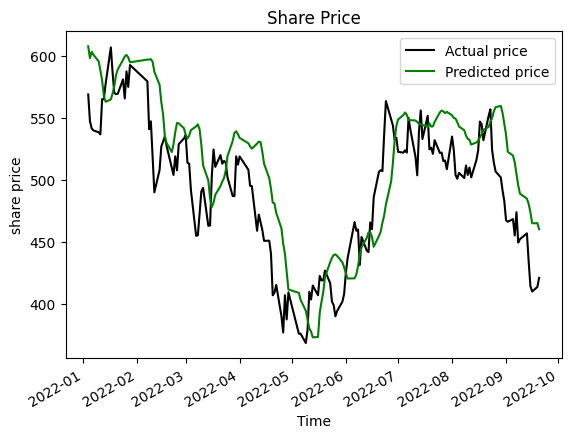

In [33]:
# create a dataframe and use the index from another dataframe
predicted_prices = pd.DataFrame(predicted_prices, index = actual_prices.index)
plt.plot(actual_prices, color='black', label=f'Actual price')
plt.plot(predicted_prices, color='green', label='Predicted price')
plt.title('Share Price')
plt.xlabel('Time')
plt.ylabel('share price')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()